**1. 데이터 다운**  
출처: https://www.kaggle.com/bittlingmayer/amazonreviews

In [0]:
!git clone https://github.com/taesunwhang/sentiment_analysis_tutorial/
!mv /content/sentiment_analysis_tutorial/amazon_reviews/* .
!rm -r sentiment_analysis_tutorial

**2. 패키지 선언 및 Glove 다운로드**

In [0]:
import os
import numpy as np
import nltk
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')

#Glove 다운로드
#출처: https://nlp.stanford.edu/projects/glove/
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

**3. 학습 데이터와 평가 데이터**



In [0]:
def read_dataset(dataset_type):
  max_seq_len = 0
  with open("./%s.txt" % dataset_type, "r", encoding="utf-8") as fr_handle:
    labels, sentences = [], []
    for line in fr_handle:
      if line.strip() == 0:
        continue
      label = line.split(' ')[0]
      label = 0 if label == "__label__1" else 1 # 부정이면 0, 긍정이면 1

      sentence = ' '.join(line.split(' ')[1:])
      tokenized_sentence = nltk.word_tokenize(sentence) #단어 단위 분리
      max_seq_len = max(max_seq_len, len(tokenized_sentence))#가장 긴 문장길이 구하기 for Padding

      labels.append(label)
      sentences.append(sentence)
    
    return labels, sentences, max_seq_len

TRAIN_LABELS, TRAIN_SENTENCES, TRAIN_MAX_SEQ_LEN = read_dataset("train") #학습데이터 읽기
TEST_LABELS, TEST_SENTENCES, TEST_MAX_SEQ_LEN = read_dataset("test") #테스트데이터 읽기
MAX_SEQUENCE_LEN = max(TRAIN_MAX_SEQ_LEN, TEST_MAX_SEQ_LEN) #Train과 Test 전체에서 가장 긴 길이

print("Train : ", len(TRAIN_SENTENCES))
for train_label, train_sent in zip(TRAIN_LABELS, TRAIN_SENTENCES[0:10]):
  print(train_label, ':' ,train_sent)

print()
print("Test : ", len(TEST_SENTENCES))
for test_label, test_sent in zip(TEST_LABELS, TEST_SENTENCES[0:10]):
  print(test_label, ':' ,test_sent)

print("MAX_SEQUENCE_LEN", MAX_SEQUENCE_LEN)
with open("./vocab.txt", "r", encoding="utf-8") as vocab_handle:
  VOCAB = [line.strip() for line in vocab_handle if len(line.strip()) > 0]
  print("Total vocabulary", VOCAB)

**4. Keras를 통한 전처리 과정**  
1) Text를 tokenize하여 id 값으로 변경해 줍니다. (tokenizer.texts_to_sequences)  
2) id로 변경해준 문장들을 모두 문장 최대 길이로 padding 처리해 줍니다. (pad_sequences)


In [0]:
tokenizer = Tokenizer(num_words=len(VOCAB), lower=True, char_level=False) #토크나이저 생성
tokenizer.fit_on_texts(TRAIN_SENTENCES) #토큰나이즈 진행
TRAIN_SEQUENCES = tokenizer.texts_to_sequences(TRAIN_SENTENCES)#id로 변경
TEST_SEQUENCES = tokenizer.texts_to_sequences(TEST_SENTENCES)#id로 변경
VOCAB_SIZE = len(tokenizer.word_index) + 1

print(TRAIN_SENTENCES[2])
print(TRAIN_SEQUENCES[2])

X_train = pad_sequences(TRAIN_SEQUENCES, padding='post', maxlen=MAX_SEQUENCE_LEN) #패딩진행
X_test = pad_sequences(TEST_SEQUENCES, padding='post', maxlen=MAX_SEQUENCE_LEN) #패딩진행
print("PAD_SEQUENCES COMPLETES")
print(X_train[0])
print(MAX_SEQUENCE_LEN)

**5. 모델 설정**  
1) Random으로 초기화된 임베딩이 아닌 pre-trained 된 GLoVE 임베딩으로 학습하고자 합니다.  
2) 따라서 학습 코퍼스에 있는 단어들 중 GLoVE 임베딩에 있는 단어들을 GLoVE 임베딩으로 초기화 해줍니다.  
3) 본 실험에서는 GLoVE 임베딩 크기가 50인 것과 100인 것을 통해 실험을 진행해 봅니다.  

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

EMBEDDING_DIM = 50 #100
embedding_matrix = create_embedding_matrix(
    './glove.6B.50d.txt',
    tokenizer.word_index, EMBEDDING_DIM
    )

**6. Accuracy와 Loss 시각화**  

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

**7. CNN 모델 선언**  
1) Convolution 필터를 앞서 배운 것처럼 여러 개를 사용해 봅시다.  
2) 본 모델은 필터의 Window Size가 2, 3, 4, 5인 필터 각 100개씩을 사용해 모델을 학습합니다. 다양한 크기의 필터를 사용하면 성능이 더 올라갈까요?  
3) 정답은 "올라갑니다." 입니다. Convolution 필터가 보는 단어의 갯수가 다양하게 되기 때문에 문장의 local 정보와 global 정보 모두를 학습할 수 있게 됩니다. 그럼 실험을 통해 확인해 볼까요?  











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 273)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 273, 50)      2476650     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 272, 100)     10100       embedding_1[0][0]                
_____________________________________________________________________

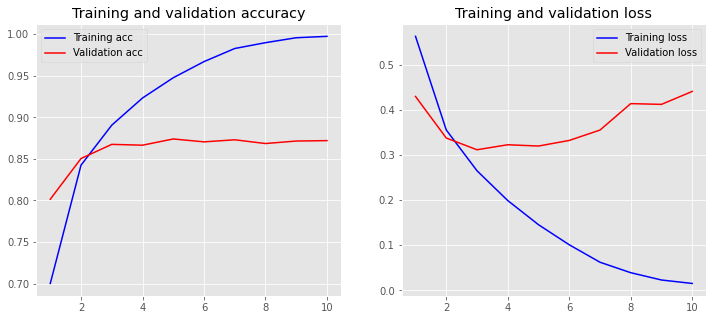

In [0]:
from keras.models import Sequential
from keras import layers
from keras.models import Model

seq_input = layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')

seq_embedded = layers.Embedding(VOCAB_SIZE, 
                           EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LEN, 
                           trainable=True)(seq_input)

filters = [2,3,4,5]
conv_models = []
for filter in filters:
  conv_feat = layers.Conv1D(filters=100, 
                            kernel_size=filter, 
                            activation='relu',
                            padding='valid')(seq_embedded) #Convolution Layer
  pooled_feat = layers.GlobalMaxPooling1D()(conv_feat) #MaxPooling
  conv_models.append(pooled_feat)

conv_merged = layers.concatenate(conv_models, axis=1) #filter size가 2,3,4,5인 결과들 Concatenation

model_output = layers.Dropout(0.2)(conv_merged)
model_output = layers.Dense(10, activation='relu')(model_output)
logits = layers.Dense(1, activation='sigmoid')(model_output)

model = Model(seq_input, logits) #(입력,출력)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

#학습 시작
history = model.fit(X_train, TRAIN_LABELS,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, TEST_LABELS),
                    batch_size=128)
# 결과 시각화
plot_history(history)

In [0]:
from keras.models import load_model
model.save('KU_NLP') #모델 저장하기

#모델 평가
test_loss,test_acc=model.evaluate(X_test,TEST_LABELS)
print("Test_acc: ",test_acc)

In [0]:
from keras.models import load_model
model2 = load_model('KU_NLP') #모델 로딩하기 

from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)